In [24]:
import random
import subprocess
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime
import numpy as np
from collections import defaultdict
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from collections import defaultdict
import plotly.express as px

sns.set(style="whitegrid")

![Image](images/original.png) 

![Image](images/bert-like-before.png) 

![Image](images/bert-like-after.png) 

In [25]:
def read_csv(file_name):
    df = pd.read_csv(file_name)
    df.columns = df.columns.str.strip()
    df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
    df = df.sort_values(by=['row', 'col'])
    return df

bert_row_df = read_csv("graph-data/bert-row-5.txt")
bert_col_df = read_csv("graph-data/bert-col-5.txt")
bert_row_col_df = read_csv("graph-data/bert-row-col-5.txt")

,model,row,col,format,prop,before,after,analysis,load,comp,run,memory
0,bert,0.1,0.0,SparseDense,0,0.004743,0.004743,0.000000,5.378360,0.178356,11.320840,659.0914
5,bert,0.1,0.0,SparseDense,1,0.004743,0.004743,0.000019,5.380478,0.177294,11.557220,659.1164
10,bert,0.1,0.0,DD,0,0.004743,0.004743,0.000000,5.344786,0.173396,12.055180,631.7224
1,bert,0.3,0.0,SparseDense,0,0.014276,0.014276,0.000000,5.378156,0.177108,11.126440,649.5050
6,bert,0.3,0.0,SparseDense,1,0.014276,0.014276,0.000019,5.402500,0.175796,11.097520,649.4392
11,bert,0.3,0.0,DD,0,0.014276,0.014276,0.000000,5.621162,0.173210,12.050920,631.7482
2,bert,0.5,0.0,SparseDense,0,0.023810,0.023810,0.000000,5.478734,0.177588,10.638320,631.9102
7,bert,0.5,0.0,SparseDense,1,0.023810,0.023810,0.000020,5.489346,0.177874,10.549780,631.8276
12,bert,0.5,0.0,DD,0,0.023810,0.023810,0.000000,5.868968,0.173491,12.025340,631.7990
3,bert,0.7,0.0,SparseDense,0,0.033319,0.033319,0.000000,5.550276,0.177812,10.238680,623.8226


In [160]:
def plot_runtime(data_frame):
    df = data_frame.copy()
    df['sparsity'] = df.apply(lambda row: f"({row['row']}, {row['col']})", axis=1)
    df['config'] = df.apply(lambda row: "Dense" if row['format'].strip() == 'DD' else( 'Sparse + Prop' if row['prop'] == 1 else 'Sparse'), axis=1)
    df = df.sort_values(by=['config'])
    fig = go.Figure()
    df = pd.DataFrame(df)

    current_x = 0

    x_labels = []
    for config in df['config'].unique():
        x_positions = []
        for i in range(len(df[df['config'] == config])):
            x_positions.append(i * 5 + current_x)
        current_x += 1

        # fig.add_trace(go.Bar(
        #     x=x_pos,
        #     y=sparsity_data['sparse_with_prop_size'],
        #     name=f'{sparsity_names[sparsity]} (With Prop)',
        #     marker_color=sparsity_colors[sparsity],
        #     marker_line_width=2,
        #     marker_line_color='black',
        #     opacity=0.9,
        #     width=0.6,
        #     hovertemplate=(
        #         'Benchmark: %{customdata[0]}<br>' +
        #         'Sparsity: %{customdata[1]}%<br>' +
        #         'With Propagation: %{y:.3f} (normalized)<br>' +
        #         'Absolute Size: %{customdata[2]:.3f}<br>' +
        #         'Reduction: %{customdata[3]:.1f}%<br>' +
        #         '<extra></extra>'
        #     ),
        #     customdata=np.column_stack((
        #         sparsity_data['benchmark_id'],
        #         sparsity_data['sparsity'] * 100,
        #         sparsity_data['sparse_with_prop_absolute'],
        #         (1 - sparsity_data['sparse_with_prop_size'] / sparsity_data['sparse_no_prop_size']) * 100
        #     ))
        # ))
        config_data = df[df['config'] == config]
        
        fig.add_trace(go.Bar(
            x=x_positions,
            y=config_data['run'],
            marker_line_width=2,
            marker_line_color='black',
            opacity=0.9,
            width=0.6,
            name=config,
            #color="config",
            #barmode="group",
            #labels={"sparsity": "Row/Col Sparsity", "run": "Runtime (s)"},
            #title="Sparsity Ratio Increase",
            #color_discrete_sequence=px.colors.qualitative.Safe,
            #marker_color='rgba(214, 39, 40, 0.8)',
            #marker_line_width=1,
            #marker_line_color='black',
            #opacity=0.9,
            #width=0.7,
            # hovertemplate=(
            #     'Benchmark: %{x}<br>' +
            #     'Tensor Size: %{y:.3f}<br>' +
            #     'File: %{customdata}<br>' +
            #     '<extra></extra>'
            # ),
            #customdata=df['format']
        ))

    fig.update_layout(
    xaxis=dict(
        tickmode="array",
        tickvals=[(idx * 5 + 1) for idx, _ in enumerate(df['sparsity'])],
        ticktext=df['sparsity'],
    ))
    fig.show()

def plot_memory():
    pass
def plot_sparsity():
    pass

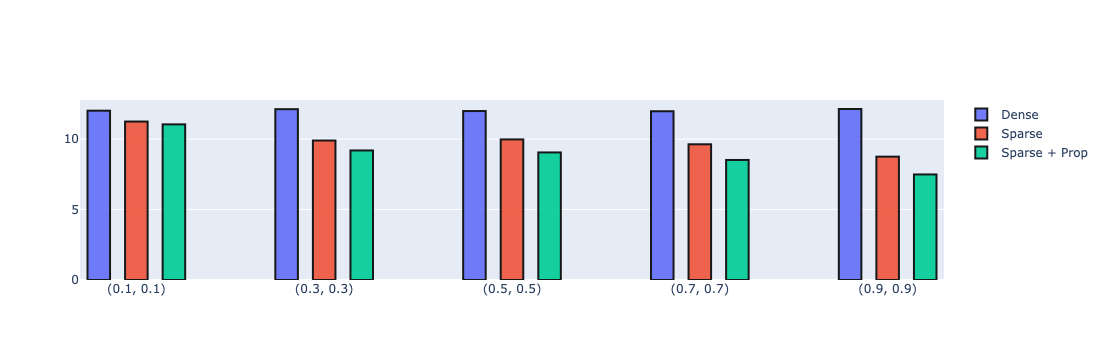

In [161]:
plot_runtime(bert_row_col_df)

In [128]:
#only column sparsity
runs = [["0.0", "0.1", "SparseDense", "0"], ["0.0", "0.3", "SparseDense", "0"], ["0.0", "0.5", "SparseDense", "0"], ["0.0", "0.7", "SparseDense", "0"], ["0.0", "0.9", "SparseDense", "0"], ["0.0", "0.1", "SparseDense", "1"], ["0.0", "0.3", "SparseDense", "1"], ["0.0", "0.5", "SparseDense", "1"], ["0.0", "0.7", "SparseDense", "1"], ["0.0", "0.9", "SparseDense", "1"], ["0.0", "0.1", "DD", "0"], ["0.0", "0.3", "DD", "0"], ["0.0", "0.5", "DD", "0"], ["0.0", "0.7", "DD", "0"], ["0.0", "0.9", "DD", "0"]]

#only row sparsity
#runs = [["0.1", "0.0", "SparseDense", "0"], ["0.3", "0.0", "SparseDense", "0"], ["0.5", "0.0", "SparseDense", "0"], ["0.7", "0.0", "SparseDense", "0"], ["0.9", "0.0", "SparseDense", "0"], ["0.1", "0.0", "SparseDense", "1"], ["0.3", "0.0", "SparseDense", "1"], ["0.5", "0.0", "SparseDense", "1"], ["0.7", "0.0", "SparseDense", "1"], ["0.9", "0.0", "SparseDense", "1"], ["0.1", "0.0", "DD", "0"], ["0.3", "0.0", "DD", "0"], ["0.5", "0.0", "DD", "0"], ["0.7", "0.0", "DD", "0"], ["0.9", "0.0", "DD", "0"]]

#row and column sparsity
#runs = [["0.1", "0.1", "SparseDense", "0"], ["0.3", "0.3", "SparseDense", "0"], ["0.5", "0.5", "SparseDense", "0"], ["0.7", "0.7", "SparseDense", "0"], ["0.9", "0.9", "SparseDense", "0"], ["0.1", "0.1", "SparseDense", "1"], ["0.3", "0.3", "SparseDense", "1"], ["0.5", "0.5", "SparseDense", "1"], ["0.7", "0.7", "SparseDense", "1"], ["0.9", "0.9", "SparseDense", "1"], ["0.1", "0.1", "DD", "0"], ["0.3", "0.3", "DD", "0"], ["0.5", "0.5", "DD", "0"], ["0.7", "0.7", "DD", "0"], ["0.9", "0.9", "DD", "0"]]

#all
#runs = [["0.0", "0.1", "SparseDense", "0"], ["0.0", "0.3", "SparseDense", "0"], ["0.0", "0.5", "SparseDense", "0"], ["0.0", "0.7", "SparseDense", "0"], ["0.0", "0.9", "SparseDense", "0"], ["0.0", "0.1", "SparseDense", "1"], ["0.0", "0.3", "SparseDense", "1"], ["0.0", "0.5", "SparseDense", "1"], ["0.0", "0.7", "SparseDense", "1"], ["0.0", "0.9", "SparseDense", "1"], ["0.0", "0.1", "DD", "0"], ["0.0", "0.3", "DD", "0"], ["0.0", "0.5", "DD", "0"], ["0.0", "0.7", "DD", "0"], ["0.0", "0.9", "DD", "0"], ["0.1", "0.0", "SparseDense", "0"], ["0.3", "0.0", "SparseDense", "0"], ["0.5", "0.0", "SparseDense", "0"], ["0.7", "0.0", "SparseDense", "0"], ["0.9", "0.0", "SparseDense", "0"], ["0.1", "0.0", "SparseDense", "1"], ["0.3", "0.0", "SparseDense", "1"], ["0.5", "0.0", "SparseDense", "1"], ["0.7", "0.0", "SparseDense", "1"], ["0.9", "0.0", "SparseDense", "1"], ["0.1", "0.0", "DD", "0"], ["0.3", "0.0", "DD", "0"], ["0.5", "0.0", "DD", "0"], ["0.7", "0.0", "DD", "0"], ["0.9", "0.0", "DD", "0"], ["0.1", "0.1", "SparseDense", "0"], ["0.3", "0.3", "SparseDense", "0"], ["0.5", "0.5", "SparseDense", "0"], ["0.7", "0.7", "SparseDense", "0"], ["0.9", "0.9", "SparseDense", "0"], ["0.1", "0.1", "SparseDense", "1"], ["0.3", "0.3", "SparseDense", "1"], ["0.5", "0.5", "SparseDense", "1"], ["0.7", "0.7", "SparseDense", "1"], ["0.9", "0.9", "SparseDense", "1"], ["0.1", "0.1", "DD", "0"], ["0.3", "0.3", "DD", "0"], ["0.5", "0.5", "DD", "0"], ["0.7", "0.7", "DD", "0"], ["0.9", "0.9", "DD", "0"]]

repeats = 10
binary = "../../build/benchmark"
graph_name = "bert"

In [6]:
def load(file_name: str):
    results = []
    with open(file_name, "rt") as file:
        for line in file.readlines()[1:]:
            data = line.replace(' ', '').split(',')
            left_sparsity = float(data[1])
            right_sparsity = float(data[2])
            fmt = data[3]
            opt = data[4]
            analysis = float(data[7])
            load = float(data[8])
            comp = float(data[9])
            runtime = float(data[10])
            memory = float(data[11].replace('\n', ''))
            mean_metrics = {
                "config": f"{left_sparsity},{right_sparsity},{fmt},opt={opt}",
                "analysis": analysis, "load": load, "compilation": comp, "runtime": runtime, "memory": memory
            }
            results.append(mean_metrics)
    return results

In [7]:
df = pd.read_csv("graph-data/bert-col-5.txt")
df.columns = df.columns.str.strip()
df

,model,row,col,format,prop,before,after,analysis,load,comp,run,memory
0,bert,0.0,0.1,SparseDense,0,0.061663,0.061663,0.000000,5.536586,0.175895,11.058920,627.2450
1,bert,0.0,0.3,SparseDense,0,0.185593,0.185593,0.000000,6.161252,0.177142,11.132580,573.5178
2,bert,0.0,0.5,SparseDense,0,0.309524,0.309524,0.000000,6.722088,0.177013,10.391680,503.8904
3,bert,0.0,0.7,SparseDense,0,0.433152,0.433152,0.000000,7.147218,0.177910,10.272820,471.1178
4,bert,0.0,0.9,SparseDense,0,0.557082,0.557082,0.000000,7.571558,0.178212,10.149840,397.8068
5,bert,0.0,0.1,SparseDense,1,0.061663,0.074475,0.000020,5.585858,0.177553,11.273640,637.2608
6,bert,0.0,0.3,SparseDense,1,0.185593,0.215582,0.000020,6.233630,0.177102,10.007626,558.3836
7,bert,0.0,0.5,SparseDense,1,0.309524,0.345238,0.000018,6.807876,0.177619,9.946652,507.8364
8,bert,0.0,0.7,SparseDense,1,0.433152,0.463169,0.000020,7.213442,0.177475,9.579710,447.3850
9,bert,0.0,0.9,SparseDense,1,0.557082,0.569951,0.000018,7.616636,0.178241,8.971910,377.7920


In [8]:
def plotly(data):
    legend_map = {
        "SparseDense,opt=1": "Sparse (prop=true)",
        "SparseDense,opt=0": "Sparse (prop=false)",
        "DD,opt=0": "dense",
    }

    configs = defaultdict(lambda: {"ratios": [], "runtime": [], "memory": [], "analysis": [], "compilation": []})
    ratio_labels = []

    for entry in data:
        parts = entry["config"].split(",")
        ratio = f"({parts[0]},{parts[1]})"
        config_type = ",".join(parts[2:])
        label = legend_map.get(config_type, config_type)

        if ratio not in ratio_labels:
            ratio_labels.append(ratio)

        configs[label]["ratios"].append(ratio)
        configs[label]["runtime"].append(entry["runtime"])
        configs[label]["memory"].append(entry["memory"])
        configs[label]["analysis"].append(entry["analysis"])
        configs[label]["compilation"].append(entry["compilation"])

    def ratio_key(r):
        vals = r.strip("()").split(",")
        return float(vals[0]), float(vals[1])
    ratio_labels = sorted(ratio_labels, key=ratio_key)

    # Define color palette
    safe_colors = px.colors.qualitative.Safe

    # --- 1) Runtime Plot ---
    fig_runtime = go.Figure()
    for label, values in configs.items():
        runtime_values = [v for _, v in sorted(zip(values["ratios"], values["runtime"]), key=lambda x: ratio_key(x[0]))]
        fig_runtime.add_trace(go.Scatter(
            x=ratio_labels, y=runtime_values, mode="lines",
            name=f"Runtime ({label})"
        ))
    fig_runtime.update_layout(
        title="Runtime vs Sparsity Ratio",
        xaxis_title="Row/Col Sparsity Ratio",
        yaxis_title="Runtime (s)",
        template="plotly_white",
        colorway=safe_colors,   # <--- use Safe colors
        legend=dict(orientation="h", yanchor="top", y=-0.3,
                                     xanchor="center", x=0.5),
    )
    fig_runtime.show()

    # --- 2) Memory Plot ---
    fig_memory = go.Figure()
    for label, values in configs.items():
        memory_values = [v for _, v in sorted(zip(values["ratios"], values["memory"]), key=lambda x: ratio_key(x[0]))]
        fig_memory.add_trace(go.Scatter(
            x=ratio_labels, y=memory_values, mode="lines",
            name=f"Memory ({label})"
        ))
    fig_memory.update_layout(
        title="Memory Usage vs Sparsity Ratio",
        xaxis_title="Row/Col Sparsity Ratio",
        yaxis_title="Memory (MB)",
        template="plotly_white",
        colorway=safe_colors,   # <--- use Safe colors
        legend=dict(orientation="h", yanchor="top", y=-0.3,
                                     xanchor="center", x=0.5),
    )
    fig_memory.show()

    # --- 3) Analysis vs Compilation vs Runtime (Bars) ---
    fig_bars = go.Figure()
    for label, values in configs.items():
        if label != "Sparse (prop=true)":
            continue
        analysis_values = [v for _, v in sorted(zip(values["ratios"], values["analysis"]), key=lambda x: ratio_key(x[0]))]
        comp_values = [v for _, v in sorted(zip(values["ratios"], values["compilation"]), key=lambda x: ratio_key(x[0]))]
        runtime_values = [v for _, v in sorted(zip(values["ratios"], values["runtime"]), key=lambda x: ratio_key(x[0]))]

        fig_bars.add_trace(go.Bar(name=f"Analysis - {label}", x=ratio_labels, y=analysis_values))
        fig_bars.add_trace(go.Bar(name=f"Compilation Time - {label}", x=ratio_labels, y=comp_values))
        fig_bars.add_trace(go.Bar(name=f"Runtime - {label}", x=ratio_labels, y=runtime_values))

    fig_bars.update_layout(
        title="Analysis vs Compilation vs Runtime (Sparse + Prop)",
        xaxis_title="Row/Col Sparsity Ratio",
        yaxis_title="Time (s, log scale)",
        template="plotly_white",
        barmode='group',
        yaxis_type='log',
        colorway=safe_colors,   # <--- use Safe colors for bars
        legend=dict(orientation="h", yanchor="top", y=-0.3,
                                     xanchor="center", x=0.5),
    )
    fig_bars.show()

In [9]:
data = load("graph-data/bert-col-5.txt")
data = load("graph-data/bert-row-5.txt")
data = load("graph-data/bert-row-col-5.txt")

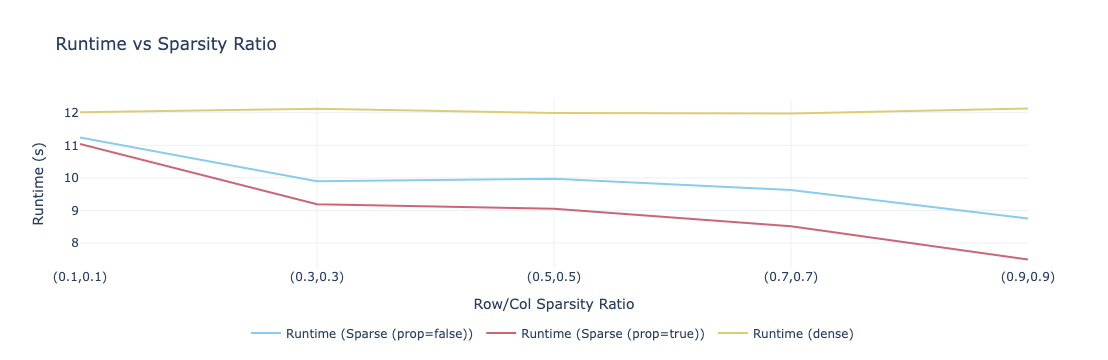

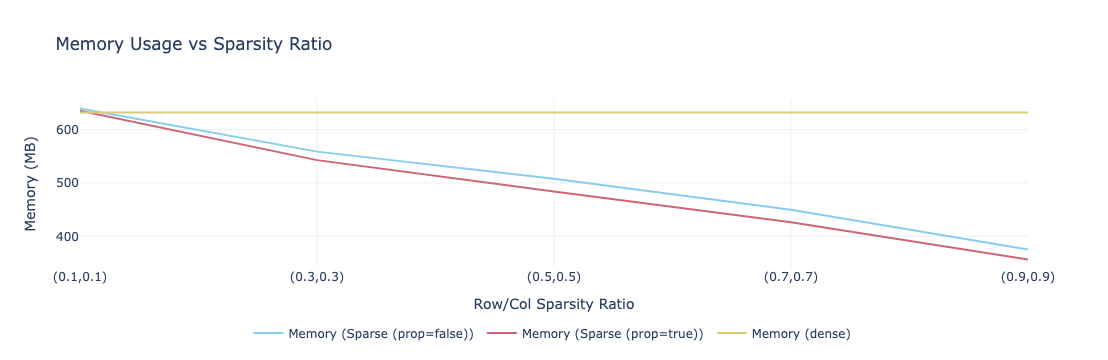

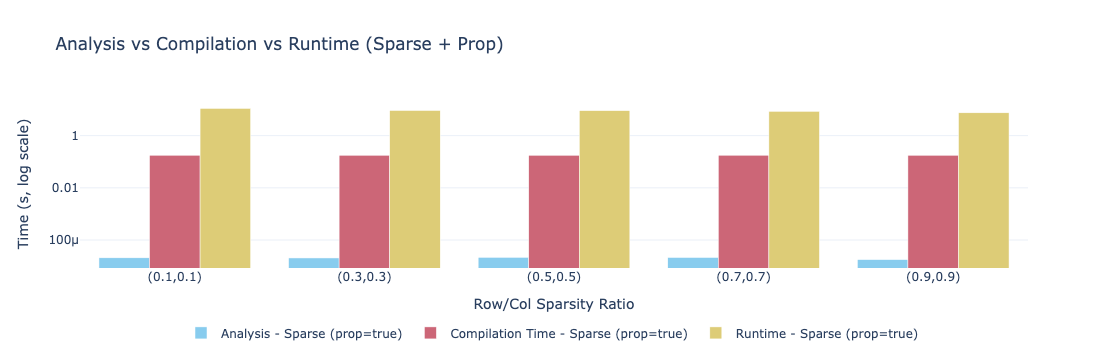

In [10]:
plotly(data)

In [11]:
def plotly_sparsity(data):
    configs = defaultdict(lambda: {"ratios": [], "runtime": []})
    ratio_labels = set()

    for entry in data:
        parts = entry["config"].split(",")
        config_type = ",".join(parts[2:])
        
        if config_type != "SparseDense,opt=1":
            continue

        if parts[0] != "0.0" and parts[1] != "0.0":
            label = "row/col"
            ratio = parts[0]
        elif parts[0] != "0.0":
            label = "row"
            ratio = parts[0]
        else:
            label = "col"
            ratio = parts[1]

        ratio_labels.add(ratio)
        configs[label]["ratios"].append(ratio)
        configs[label]["runtime"].append(entry["runtime"])

    ratio_labels = sorted(ratio_labels, key=lambda r: float(r))

    # pick Safe palette
    colors = px.colors.qualitative.Safe
    color_map = {label: colors[i % len(colors)] for i, label in enumerate(configs.keys())}

    fig = go.Figure()
    for label, values in configs.items():
        sorted_data = sorted(zip(values["ratios"], values["runtime"]), key=lambda x: float(x[0]))
        sorted_ratios, sorted_runtimes = zip(*sorted_data)

        fig.add_trace(go.Scatter(
            x=sorted_ratios,
            y=sorted_runtimes,
            mode="lines",
            name=label,
            line=dict(color=color_map[label])
        ))

    fig.update_layout(
        title="Runtime vs Sparsity Ratio (Sparse+Prop)",
        xaxis_title="Sparsity Ratio",
        yaxis_title="Runtime (s)",
        template="plotly_white",
        height=500,
        legend=dict(
            title="Sparsity Type",
            orientation="h",
            yanchor="bottom",
            y=-0.3,
            xanchor="center",
            x=0.5
        ),
    )
    fig.show()

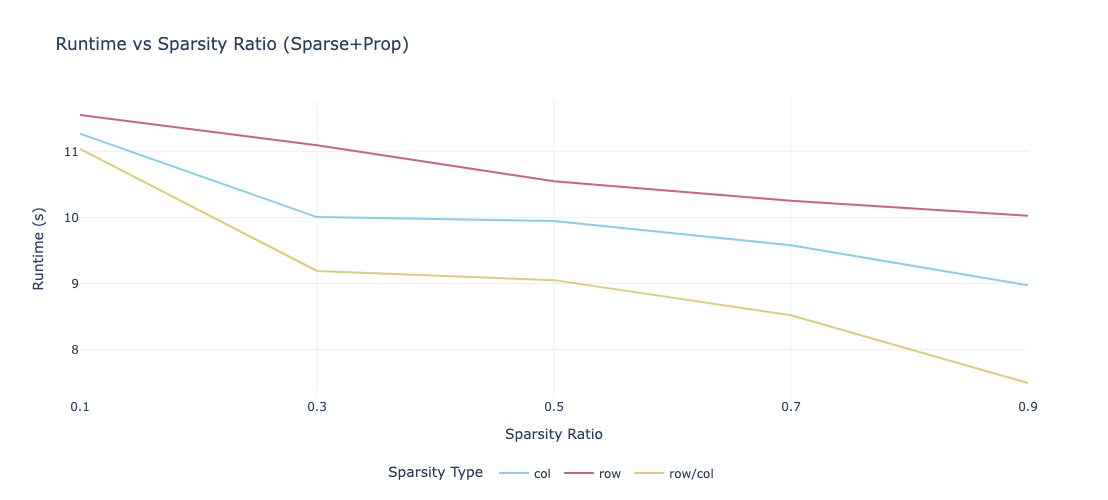

In [12]:
data = load("graph-data/bert-col-5.txt")
data.extend(load("graph-data/bert-row-5.txt"))
data.extend(load("graph-data/bert-row-col-5.txt"))
plotly_sparsity(data)